### Pytorch WorkFlows
- Getting data ready
- Building a model
- Fitting the model to data (training)
- Making predictions and evaluating a model (inference)
- Saving and loading a model
- Putting it all together

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

#### Simple linear regression model

In [18]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight + X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[1.0000],
         [1.0200],
         [1.0400],
         [1.0600],
         [1.0800],
         [1.1000],
         [1.1200],
         [1.1400],
         [1.1600],
         [1.1800]]))

In [19]:
len(X), len(y)

(50, 50)

In [20]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [28]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test,
                     predictions=None):
    
    plt.figure(figsize=(12, 8))

    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    plt.legend(prop={"size": 14})

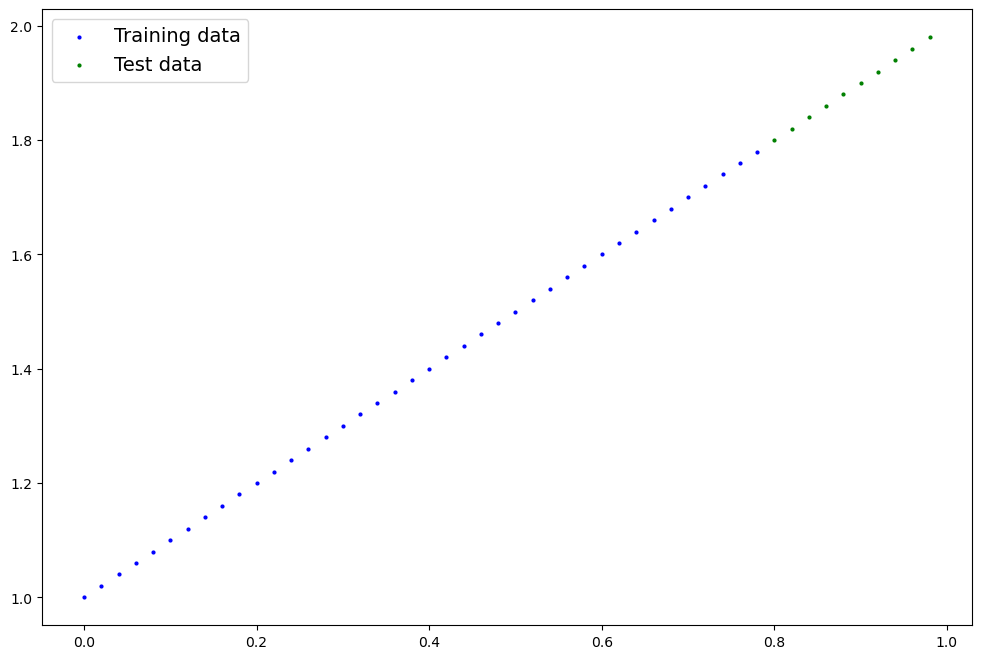

In [29]:
plot_predictions()

#### Build Model (Linear Regression)

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super.__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias
        


